# Notebook for APSAR 

Load and save S1 data and matching WOfS classifications

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import datacube
from digitalearthau.utils import wofs_fuser

In [2]:
import numpy as np
from scipy import ndimage

In [3]:
from s1_water_utils import *
from s1_water_tag_and_save import *

## Load clear WOfS data

In [4]:
areas = {
    # train
    'menindee':((142.2, 142.7),(-32.5, -32.1)), 
    'eucumbene':((148.435, 148.874),(-36.252, -35.895)), # no nodata, two orbits
    # test
    'george': ((149.27, 149.52),(-35.22, -34.97)),
    'tasmania': ((146.5,147.0),(-42.18,-41.79))
    }

area = 'tasmania'
x, y = areas[area]


In [5]:
wofs_sets =[]
for time in [('2016-01-01', '2016-06-30'), ('2016-07-01', '2016-12-31'),
             ('2017-01-01', '2017-06-30'), ('2017-07-01', '2017-12-31'),
             ('2018-01-01', '2018-06-30'), ('2018-07-01', '2018-12-31')]:
    
    wofs_query = {
    'y': y,
    'x': x,
    'time':time,
    'crs': 'EPSG:4326',
    'output_crs': 'EPSG: 3577',
    'resolution': (25, 25)
    }
    wofs_sets.append(load_clear_wofs(wofs_query, dry_months = None, clear_frac = 0.9, valid_frac = 0.7))
    

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)
/g/data/v10/public/modules/dea-env/20

In [6]:
import xarray as xr
wofs = xr.concat(wofs_sets, dim='time')

In [7]:
wofs.water.values.shape

(14, 1875, 1885)

In [8]:
wofs.time.values, len(wofs.time)

(array(['2016-11-27T23:58:48.000000000', '2016-12-22T23:52:31.000000000',
        '2017-02-15T23:58:24.000000000', '2017-03-03T23:58:18.000000000',
        '2017-03-12T23:52:02.000000000', '2017-03-19T23:58:08.000000000',
        '2017-10-06T23:52:33.000000000', '2017-11-07T23:52:34.000000000',
        '2017-11-14T23:58:43.000000000', '2017-12-09T23:52:26.000000000',
        '2018-01-10T23:52:22.000000000', '2018-03-06T23:58:07.000000000',
        '2018-09-23T23:51:58.000000000', '2018-11-17T23:58:24.000000000'],
       dtype='datetime64[ns]'), 14)

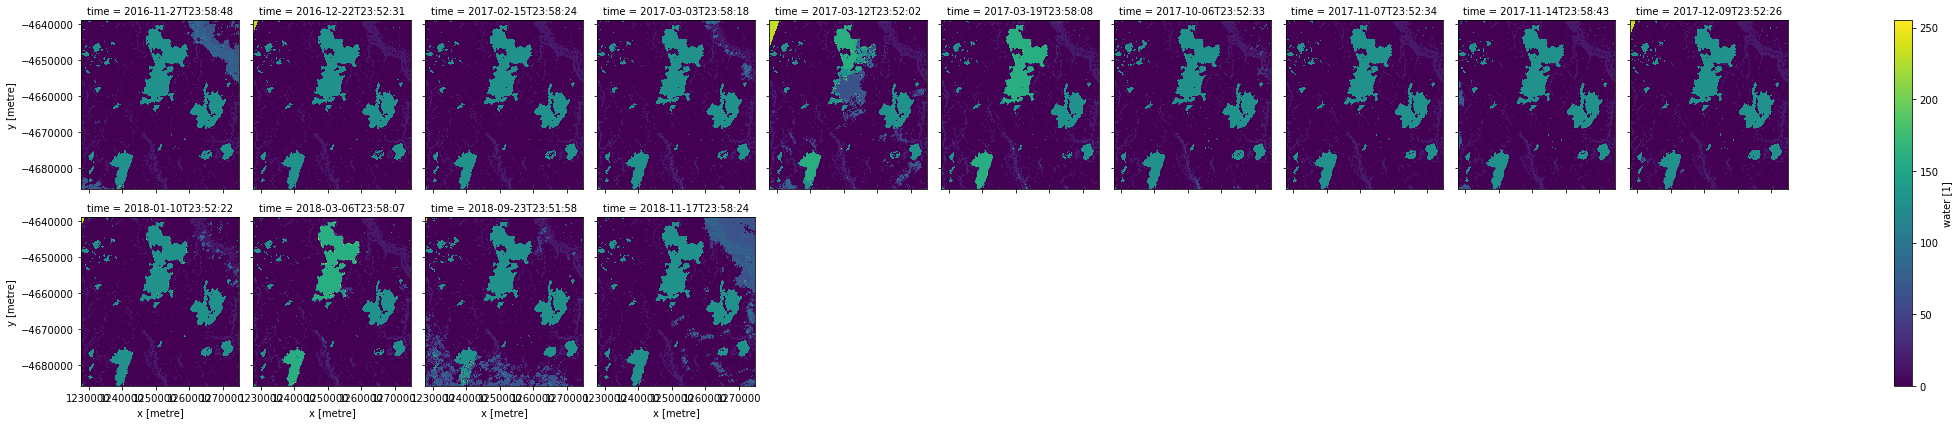

In [9]:
wofs.water.plot(col='time', col_wrap=10)

## S1 backscatter

In [10]:
query = {
    'y': y,
    'x': x,
    'time':('2016-01-01','2018-12-31'),
    'crs': 'EPSG:4326',
    'output_crs': 'EPSG: 3577',
    'resolution': (25, 25)
    }
s1_gamma0 = load_s1(query, product = 's1_gamma0_scene_v2', wofs_times=wofs.time.values)

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


In [11]:
s1_gamma0

<xarray.Dataset>
Dimensions:  (time: 16, x: 1885, y: 1875)
Coordinates:
  * time     (time) datetime64[ns] 2016-11-21T19:17:49.944522 ... 2018-11-23T19:18:02.745218
  * y        (y) float64 -4.686e+06 -4.686e+06 ... -4.639e+06 -4.639e+06
  * x        (x) float64 1.228e+06 1.228e+06 1.228e+06 ... 1.275e+06 1.275e+06
Data variables:
    vh       (time, y, x) float32 0.0016900426 0.0017576499 ... 0.0063098907
    vv       (time, y, x) float32 0.040893927 0.0071325973 ... 0.02545145
Attributes:
    crs:      EPSG: 3577

## Match times

In [12]:
wofs, s1 = match_wofs_s1(wofs, s1_gamma0, verbose=True)

                                time_ls                    time_s1
time                                                              
2016-12-22 23:52:31 2016-12-22 23:52:31 2016-12-27 19:17:49.358118
2017-02-15 23:58:24 2017-02-15 23:58:24 2017-02-13 19:17:46.853711
2017-03-12 23:52:02 2017-03-12 23:52:02 2017-03-09 19:17:46.826570
2017-03-19 23:58:08 2017-03-19 23:58:08 2017-03-21 19:17:47.036443
2017-10-06 23:52:33 2017-10-06 23:52:33 2017-10-11 19:17:56.613995
2017-11-07 23:52:34 2017-11-07 23:52:34 2017-11-04 19:17:56.637996
2017-11-14 23:58:43 2017-11-14 23:58:43 2017-11-16 19:17:56.352531
2017-12-09 23:52:26 2017-12-09 23:52:26 2017-12-10 19:17:55.586685
2018-01-10 23:52:22 2018-01-10 23:52:22 2018-01-15 19:17:54.233438
2018-03-06 23:58:07 2018-03-06 23:58:07 2018-03-04 19:17:53.374414
2018-09-23 23:51:58 2018-09-23 23:51:58 2018-09-24 19:18:02.892335


## Assign uncertain classification to WOfS

In [13]:
cleaned_wofs =clean_wofs(wofs)
cleaned_wofs

<xarray.Dataset>
Dimensions:  (time: 11, x: 1885, y: 1875)
Coordinates:
  * y        (y) float64 -4.686e+06 -4.686e+06 ... -4.639e+06 -4.639e+06
  * x        (x) float64 1.228e+06 1.228e+06 1.228e+06 ... 1.275e+06 1.275e+06
  * time     (time) datetime64[ns] 2016-12-22T23:52:31 ... 2018-09-23T23:51:58
Data variables:
    water    (time, y, x) int64 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:      EPSG: 3577

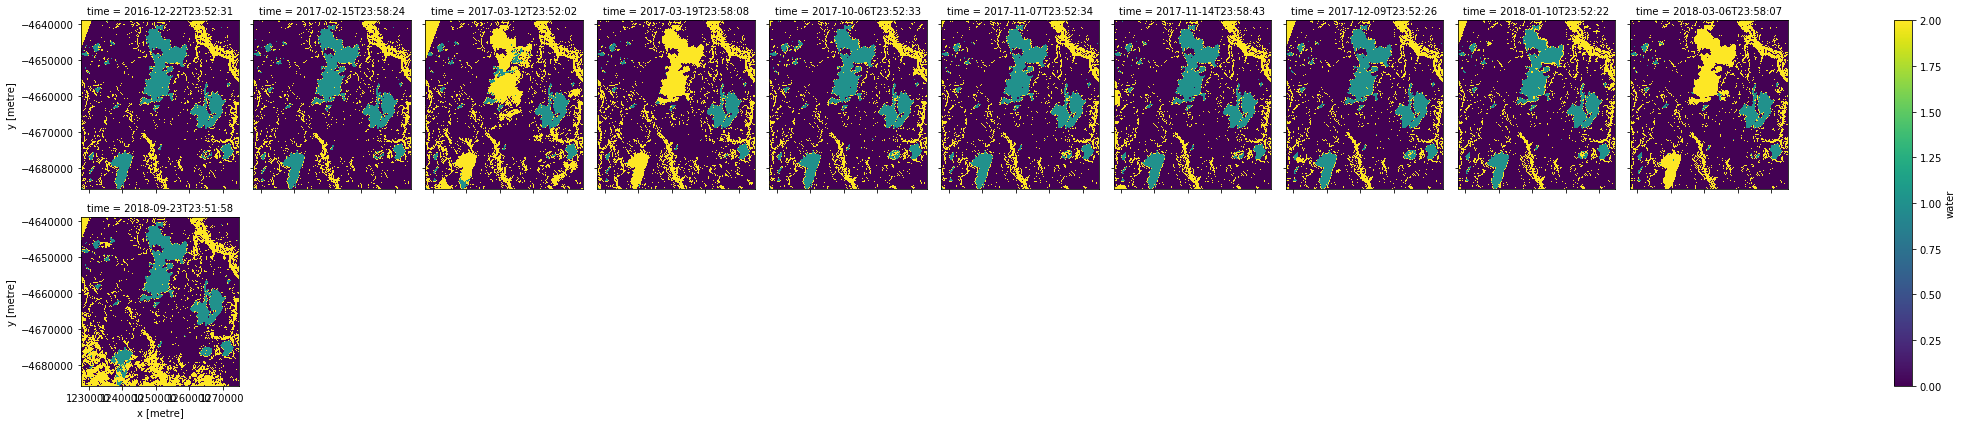

In [14]:
cleaned_wofs.water.plot(col='time',col_wrap=10)

In [15]:
(cleaned_wofs==2).groupby('time').mean().water.values

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/groupby.py:758: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)


array([0.11539636, 0.10922073, 0.23954193, 0.21863894, 0.11406401,
       0.11056778, 0.1169907 , 0.11704615, 0.12561174, 0.19128955,
       0.20221793])

## Apply speckle filter and reduce negative and extreme values

In [16]:
cleaned_s1 = clean_s1(s1, remove_high =True)

In [17]:
#fill holes with grey_dilation
for band  in list(cleaned_s1.data_vars):
    dilated = cleaned_s1[band].groupby('time').apply(ndimage.grey_dilation, footprint=disk(1))
    cleaned_s1[band] = cleaned_s1[band].where(~np.isnan(cleaned_s1[band]), dilated)

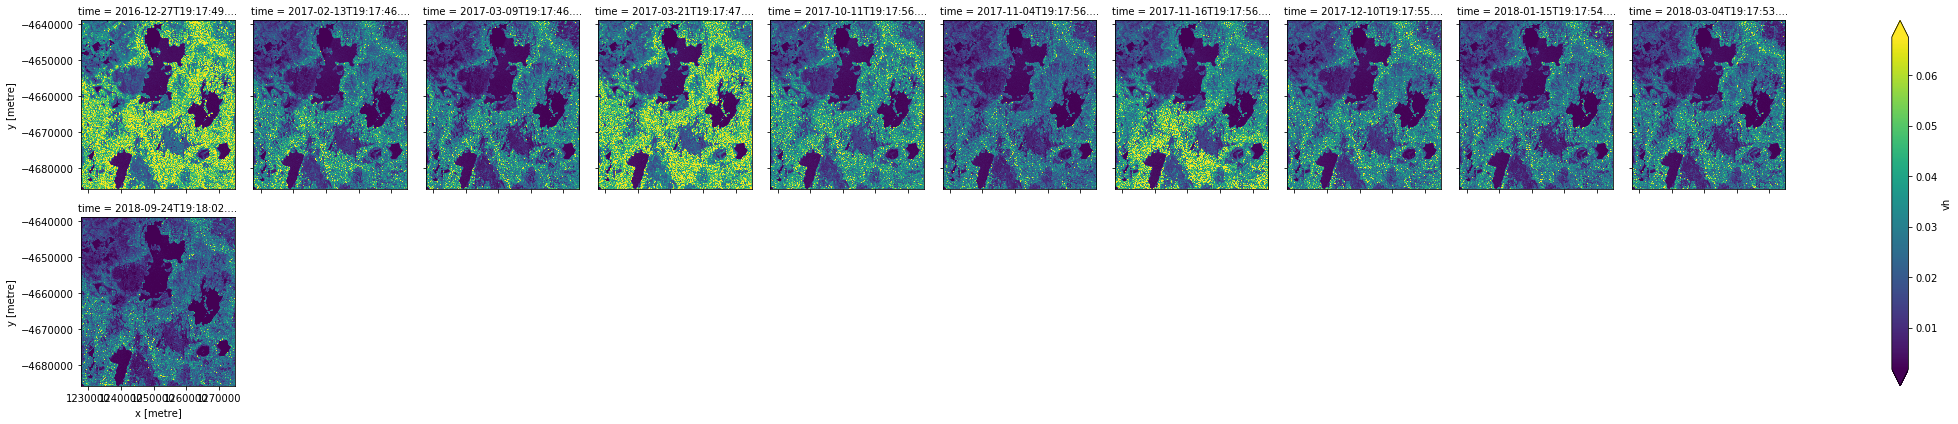

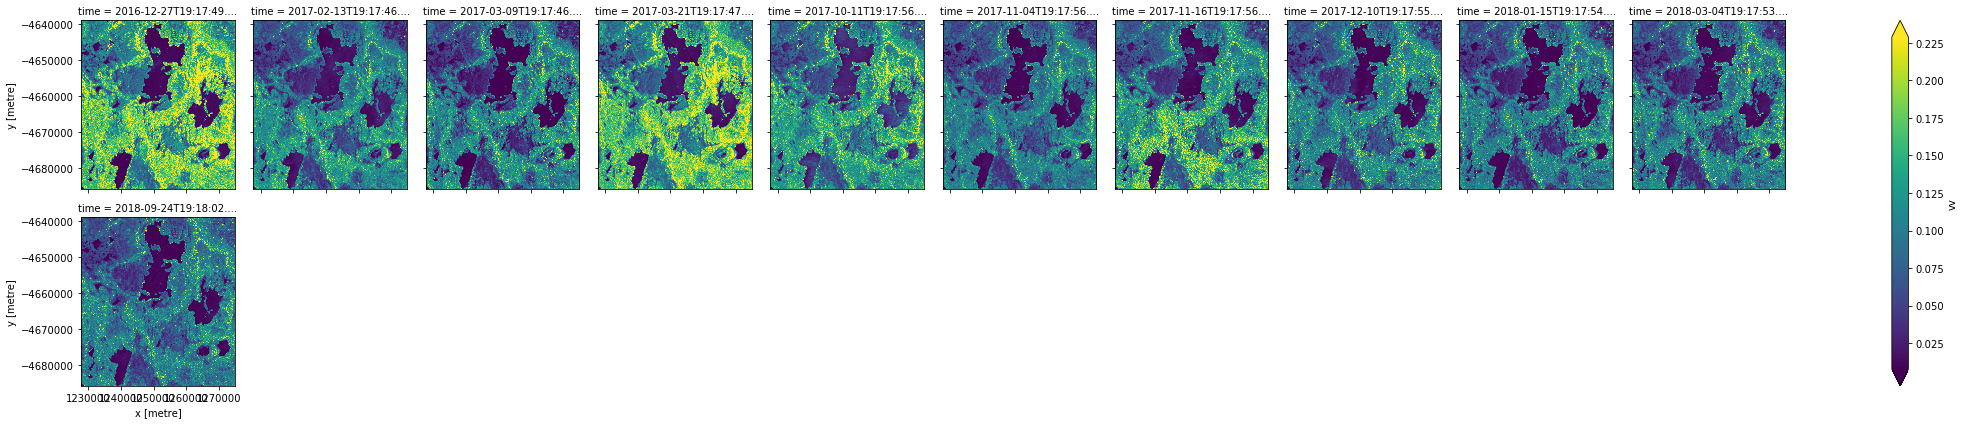

In [18]:
for band in list(cleaned_s1.data_vars):
    cleaned_s1[band].plot.imshow(col='time',robust=True, col_wrap=10)

## Save data

In [19]:
import os
os.system('rm apsar_s1_water_train_s1_%s.nc'%area)
os.system('rm apsar_s1_water_train_wofs_%s.nc'%area)
cleaned_s1 =  cleaned_s1.assign_attrs(wofs.attrs)
datacube.drivers.netcdf.write_dataset_to_netcdf(cleaned_s1, 'apsar_s1_water_train_s1_%s.nc'%area)
datacube.drivers.netcdf.write_dataset_to_netcdf(wofs*1., 'apsar_s1_water_train_wofs_%s.nc'%area)

In [20]:
!ls

apsar_brf.joblib
apsar_fig_train.eps
apsar_fig_train.png
apsar_fig_train.tiff
apsar_rusboost.joblib
apsar_s1_water_train_s1_eucumbene.nc
apsar_s1_water_train_s1_george.nc
apsar_s1_water_train_s1_menindee.nc
apsar_s1_water_train_s1_tasmania.nc
apsar_s1_water_train_wofs_eucumbene.nc
apsar_s1_water_train_wofs_george.nc
apsar_s1_water_train_wofs_menindee.nc
apsar_s1_water_train_wofs_tasmania.nc
apsar_sentinel1_train_figures.ipynb
apsar_sentinel1_water_clean_and_save.ipynb
apsar_sentinel1_water_train_supervised.ipynb
model_menindee.png
models
__pycache__
radar.conf
s1_thresholding.py
s1_thresholding.py~
s1_water_tag_and_save.py
s1_water_train_s1_eucumbene.nc
s1_water_train_s1_george.nc
s1_water_train_s1_menindee.nc
s1_water_train_wofs_eucumbene.nc
s1_water_train_wofs_george.nc
s1_water_train_wofs_menindee.nc
s1_water_utils.py
s1_water_utils.py~
sentinel1_water_classify.ipynb
sentinel1_water_clean_and_save_backsc_and_dualpol.ipynb
sentinel1_water_train_6_bands.ipynb
sentinel1_water_train.ipy

In [21]:
wofs.x.values, wofs.y.values

(array([1227787.5, 1227812.5, 1227837.5, ..., 1274837.5, 1274862.5,
        1274887.5]),
 array([-4685837.5, -4685812.5, -4685787.5, ..., -4639037.5, -4639012.5,
        -4638987.5]))